#  Unsupervised learning addition model with generator  -  using loopy encoder and decoder method

Author: S. Menary [sbmenary@gmail.com]

Date: 15/6/2023  (last update: 15/6/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $\sum_{i=1}^N A_i$ for a configurable number $N$ of integers $A_i\in\mathbb{Z}$, and the output is a set of logits representing the probability of each token in the output sequence. Integers may have a configurable number of digits. At inference time, chains of text are generated auto-regressively until the terminate-sequence token is reached. The loss function is a sparse categorical entropy.

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, os, sys

##  Import entire pypi packages
import tensorflow as tf

##  Remove tensorflow INFO messages
tf.get_logger().setLevel('WARNING')

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import AdamW
from mathsformer import config, data, transformers, utils
from mathsformer import selfsupervised_learning_addition_model_backend as backend


## 1. Configure run

Set configuration variables for entire program

In [2]:
##==============================##
##   Set custom config values   ##
##==============================##

custom_config = {
    "global" : {
        "base_seed"        : -1,
        "working_dir"      : "SSL_loopy_enc_dec_notebook_[global>problem_tag]_embed[model>ndim_embedding]_enc_[model>encoder>num_blocks]blocks_[model>encoder>num_loops]loops_width[model>encoder>ndim_ff_hidden]_dec_[model>decoder>num_blocks]blocks_[model>decoder>num_loops]loops_width[model>decoder>ndim_ff_hidden]_post[model>post_decoder>num_layers]_width[model>post_decoder>ndim]_idem[model>idempotent_size]_[date]",
        "problem_tag"      : "int1234_num1245",
        "log_lvl_iostream" : logging.INFO,
        "log_lvl_fstream"  : logging.DEBUG,
    },
    "data" : {
        "train_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [1, 2, 4, 5],
            "batch_size"       : 32,
            "num_batches"      : 2000,
            "gen_base_seed"    : 104,
            "gen_reproducible" : False, 
        },
        "val_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [3],
            "batch_size"       : 32,
            "num_batches"      : 50,
            "gen_base_seed"    : 105,
            "gen_reproducible" : True,
        },
        "test_data" : {
            "int_lengths"      : [1, 2, 3, 4],
            "num_ints"         : [6],
            "batch_size"       : 32,
            "num_batches"      : 100,
            "gen_base_seed"    : 106,
            "gen_reproducible" : True,
        },
        "characters"              : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"               : 'M',
        "seq_start_char"          : 'B',
        "seq_end_char"            : 'E',
        "negative_char"           : 'N',
        "dtype"                   : "int32",
    },
    "model" : {
        "load_pretrained_model" : None,
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "jit_compile"           : False,
        "use_old_loss"          : True,
        "optimizer"             : AdamW,
        "optimizer_args"        : {"learning_rate":1e-4, "weight_decay":2e-2},
        "idempotent_size"       : 2,
        "positional_encoding" : {
            "num_freqs"         : 64,
            "min_period"        : 4,
            "max_period"        : 1000,
            "learnable"         : True,
        },
        "ndim_embedding"        : 128,
        "comb_type"             : 'average',
        "pre_encoder"           : {
            "num_layers"        : -1,
            "ndim"              : 256,
            "skip_connect"      : True,
        },
        "pre_decoder" : {
            "num_layers"        : -1,
            "ndim"              : 256,
            "skip_connect"      : True,
        },
        "encoder" : {
            "num_blocks"        : 2,
            "num_loops"         : 5,
            "num_heads"         : 8,
            "ndim"              : 128,
            "ndim_att_hidden"   : 128,
            "ndim_ff_hidden"    : 512,
            "skip_connect"      : True,
        },
        "decoder" : {
            "num_blocks"        : 2,
            "num_loops"         : 1,
            "num_heads"         : 8,
            "ndim"              : 128,
            "ndim_att_hidden"   : 128,
            "ndim_ff_hidden"    : 512,
            "skip_connect"      : True,
        },
        "post_decoder" : {
            "num_layers"        : 3,
            "ndim"              : 512,
        },
    },
    "training" : {
        "train"          : True,
        "max_epochs"     : 100000,
        "log_after_epoch" : {
            "do"          : True,
            "log_lvl"     : logging.DEBUG,
        },
        "early_stopping" : {
            "do"                   : True,
            "patience"             : 6,
            "monitor"              : "loss",
            "mode"                 : "min",
            "restore_best_weights" : True,
        },
        "model_checkpoint" : {
            "do"       : True,
            "filename" : "model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras",
        },
        "layer_weights_record" : {
            "do"               : True,
            "batch_frequency"  : 2000,
            "recursive"        : True,
        },
        "adaptive_learning_rate" : {
            "do"                 : True,
            "decay_factor"       : 0.2,
            "monitor"            : "loss",
            "mode"               : "min",
            "patience"           : 2,
            "log_lvl"            : logging.DEBUG,
        },
        "print_tables_during_training" : {
            "do"        : True,
            "num_print" : 10,
        },
    },
    "evaluate" : {
        "num_print"            : 50,
        "save_model"           : True,
        "plot_weights"         : False,
        "plot_training_curves" : True,
    },
}


In [3]:
##===================================##
##   Load and validate full config   ##
##===================================##

##  Create config object containing default values
cfg = config.Config(backend.DEFAULT_CONFIG)

##  Override with custom values
cfg.load_dict(custom_config)

##  Validate config
backend.validate_config(cfg)

##  Print success
print(utils.fancy_message(f"Config created"))

##  For convenience, split configs for different sections
cfg_global   = cfg["global"  ]
cfg_data     = cfg["data"    ]
cfg_model    = cfg["model"   ]
cfg_training = cfg["training"]
cfg_evaluate = cfg["evaluate"]


===   Config created   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = utils.initialise_program(
    "unsupervised_learning_addition_model_generator (notebook)", 
    working_dir       = cfg_global["working_dir"], 
    cfg               = cfg,
    base_seed         = cfg_global["base_seed"],
    log_lvl_iostream  = cfg_global["log_lvl_iostream"],
    log_lvl_fstream   = cfg_global["log_lvl_fstream" ],
)


===   Working directory created at SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idem2_2023_06_27   ===
   INFO initialise_logging: Begin logging on 2023-06-27 at 16:57:45
   INFO initialise_program: Program description: unsupervised_learning_addition_model_generator (notebook)
   INFO initialise_program: Working directory: SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idem2_2023_06_27
   INFO log_versions: ------------------------------------------------------+------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+------------------------------------------------------
   INFO log_versions:                                               Python  |  3.11.3 (main, May 15 2023, 

   INFO log_versions:                                       prompt_toolkit  |  3.0.38
   INFO log_versions:                                               psutil  |  5.9.5
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.5
   INFO log_versions:                                             pygments  |  2.15.1
   INFO log_versions:                                            pyparsing  |  3.1.0
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.31.0
   INFO log_versions:                                 requests.__version__  |  2.31.0
   INFO log_versions:                                        

   INFO initialise_program: Registered config value data > val_data > batch_size: 32
   INFO initialise_program: Registered config value data > val_data > num_batches: 50
   INFO initialise_program: Registered config value data > val_data > gen_base_seed: 105
   INFO initialise_program: Registered config value data > val_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > test_data > int_lengths: [1, 2, 3, 4]
   INFO initialise_program: Registered config value data > test_data > num_ints: [6]
   INFO initialise_program: Registered config value data > test_data > batch_size: 32
   INFO initialise_program: Registered config value data > test_data > num_batches: 100
   INFO initialise_program: Registered config value data > test_data > gen_base_seed: 106
   INFO initialise_program: Registered config value data > test_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > characters: ['M', 'B', 'E', 'N', '0', '1', '2', 

##  3. Create training data

###  Create tokeniser

Tokeniser object handles the transformation from strings to tensors and back again

In [5]:
##======================##
##   Create tokeniser   ##
##======================##

token_transform = data.TokenTransform.from_dictionary(cfg_data)
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


###  Create data generators for train/val/test sets

Data generators create tensor inputs/outputs for the model on-the-fly


In [6]:
##============================##
##   Create data generators   ##
##============================##

negative_char = cfg_data.get("negative_char")
train_gen, train_gen_reproducible, val_gen, test_gen = backend.get_data_generators(cfg_data, token_transform)


   INFO get_data_generators: Training data generator created with the following config: Generator of [1, 2, 4, 5] integers of length [1, 2, 3, 4] in 2000 batches of size 32 (base_seed=104, reproducible=False)
   INFO get_data_generators: Output shapes for a test batch are ((32, 25), (32, 6)), (32, 6)
   INFO get_data_generators: Validation data generator created with the following config: Generator of [3] integers of length [1, 2, 3, 4] in 50 batches of size 32 (base_seed=105, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 17), (32, 6)), (32, 6)
   INFO get_data_generators: Test data generator created with the following config: Generator of [6] integers of length [1, 2, 3, 4] in 100 batches of size 32 (base_seed=106, reproducible=True)
   INFO get_data_generators: Output shapes for a test batch are ((32, 30), (32, 7)), (32, 7)


   INFO <module>: Saving distribution of token frequencies to file SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idem2_2023_06_27/token_distribution.pdf


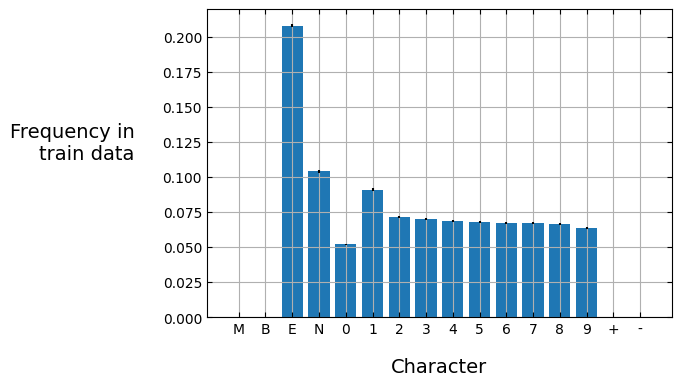

In [7]:
##=========================================================##
##   Quickly visualise distribution of token frequencies   ##
##=========================================================##

##  Imports
import numpy as np
from matplotlib import pyplot as plt

##  Get sample of train data labels
train_data_sample = np.concatenate([train_gen[i][1].numpy().flatten() for i in range(1000)])

##  Ignore masked tokens
train_data_sample = train_data_sample[train_data_sample != 0]

##  Count number for each token
chars, freqs = [], []
for token, char in train_gen.token_transform.detokeniser_dict.items() :
    chars.append(char)
    freqs.append(len(train_data_sample[train_data_sample==token]))
    
##  Normalise counts to frequency
freqs     = np.array(freqs).astype(np.float32)
freqs_err = np.sqrt(freqs)
freqs_tot = np.sum(freqs)
freqs     /= freqs_tot
freqs_err /= freqs_tot

##  Log token frequencies
for char, freq, freq_err in zip(chars, freqs, freqs_err) :
    logger.debug(f"Token '{char}' in training data with frequency {100.*freq:.1f} +- {100.*freq_err:.1f} % (masked)")

##  Plot quick bar chart of frequencies
fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(1, 1, 1)
ax.tick_params(which="both", axis="both", right=True, top=True, labelsize=10, direction="in")
ax.grid()
ax.set_xlabel("Character", fontsize=14, va="top"  , labelpad=15)
ax.set_ylabel("Frequency in\ntrain data", fontsize=14, ha="right", rotation=0, labelpad=20)

ax.bar(chars, freqs, yerr=freqs_err)

fig_fname = f"{working_dir}/token_distribution.pdf"
logger.info(f"Saving distribution of token frequencies to file {fig_fname}")

plt.savefig(fig_fname, bbox_inches="tight")
plt.show(fig)
plt.close(fig)


##  4.  Create model

Create the keras model object that handles sequence-sequence transformations from alread-tokenised data

In [8]:

from tensorflow.keras.layers     import Add, Average, Concatenate, Embedding, Input, LayerNormalization
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam

from mathsformer.tf_objects import (DecoderBlock, EncoderBlock, Enumerate, FeedForwardBlock, LearnableMixture, MaskedCategoricalAccuracy,
                                    MaskedSparseCategoricalCrossentropy, PositionalEncoding)
from mathsformer.tf_objects import scalar_masked_sparse_categorical_crossentropy, scalar_masked_categorical_accuracy


In [9]:

def create_text_to_text_model(vocab_length:int, 
                              name:str, 
                              do_compile:bool       = True,
                              use_old_loss:bool     = False,
                              dtype_in              = tf.int32, 
                              dtype                 = tf.float32, 
                              dropout:float         = 0.1, 
                              jit_compile:bool      = None,
                              optimizer             = Adam,
                              optimizer_args:dict   = None,
                              idempotent_size:int   = 1,
                              pos_enc_num_freqs:int = 32, pos_enc_min_period:float = 4, pos_enc_max_period:float = 500 , pos_enc_learnable:bool = False,
                              ndim_embedding:int          = 64, comb_type:str                = "average",
                              num_encoder_blocks:int      = 5 , ndim_encoder:int             = 64 , skip_connect_encoder:bool  = True,
                              num_decoder_blocks:int      = 5 , ndim_decoder:int             = 64 , skip_connect_decoder:bool  = True,
                              num_heads_encoder:int       = 8 , ndim_att_hidden_encoder:int  = 128, ndim_ff_hidden_encoder:int = 128, 
                              num_heads_decoder:int       = 8 , ndim_att_hidden_decoder:int  = 128, ndim_ff_hidden_decoder:int = 128, 
                              num_encoder_loops:int       = 1 , num_decoder_loops:int        = 1  ,
                              num_post_layers_decoder:int = 3 , ndim_post_layers_decoder:int = 512, 
                             ) :
    """
    """
    ##  Resolve mutable default args
    if optimizer_args is None :
        optimizer_args = {'learning_rate': 1e-3}
    
    ##=============================================##
    ##===   Input layer - Output shape [B, S]   ===##
    ##=============================================##
    x_in_enc = Input((None,), dtype=dtype_in, name=f"{name}_encoder_input_layer")
    x_in_dec = Input((None,), dtype=dtype_in, name=f"{name}_decoder_input_layer")
            
    ##===========================================================================##
    ##===  Token embedding, masking 0s - Output shape [B, S, ndim_embedding]  ===##
    ##===========================================================================##
    x_embed_enc = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_encoder_embedding")(x_in_enc)
    x_embed_dec = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_decoder_embedding")(x_in_dec)
    
    ##=========================================================================##
    ##===  Enumerate indices for positional encoding - Output shape [B, S]  ===##
    ##=========================================================================##
    x_pos_enc = Enumerate(name=f"{name}_encoder_enumerate", dtype=dtype)(x_in_enc, minimal_dims=False)
    x_pos_dec = Enumerate(name=f"{name}_decoder_enumerate", dtype=dtype)(x_in_dec, minimal_dims=False)
    
    ##========================================================================##
    ##===  Positional encoding - Output shape [B, S, 2*pos_enc_num_freqs]  ===##
    ##========================================================================##
    x_pos_enc = PositionalEncoding(num_freqs  = pos_enc_num_freqs, 
                                   min_period = pos_enc_min_period, 
                                   max_period = pos_enc_max_period, 
                                   learnable  = pos_enc_learnable,
                                   dtype      = dtype, 
                                   name       = f"{name}_encoder_position_encoding")(x_pos_enc)
    x_pos_dec = PositionalEncoding(num_freqs  = pos_enc_num_freqs, 
                                   min_period = pos_enc_min_period, 
                                   max_period = pos_enc_max_period, 
                                   learnable  = pos_enc_learnable,
                                   dtype      = dtype, 
                                   name       = f"{name}_decoder_position_encoding")(x_pos_dec)

    ##==============================================================================================##
    ##===  Combine embeddings end pos enc - Output shape [B, S, N] where N depends on comb_type  ===##
    ##==============================================================================================##
    allowed_comb_types = ["add", "sum", "average", "mean", "concat", "concatenate", "mixture"]
    match comb_type.lower() :
        case "add" | "sum" :
            x_enc = Add(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Add(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "average" | "mean" :
            x_enc = Average(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Average(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "concat" | "concatenate" :
            x_enc = Concatenate(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = Concatenate(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case "mixture" :
            x_enc = LearnableMixture(name=f"{name}_encoder_emb_and_pos", dtype=dtype)([x_embed_enc, x_pos_enc])
            x_dec = LearnableMixture(name=f"{name}_decoder_emb_and_pos", dtype=dtype)([x_embed_dec, x_pos_dec])
        case _ :
            raise RuntimeError(f"comb_type '{comb_type}' not recognised, recognised keywords are {allowed_comb_types}")
    
    ##============================================================##
    ##===  Encoder blocks - Output shape [B, S, ndim_encoder]  ===##
    ##============================================================##
    encoder_blocks = []
    for layer_idx in range(num_encoder_blocks) :
        encoder_blocks.append(EncoderBlock(
                                 ndim_encoder, 
                                 num_heads_encoder, 
                                 ndim_att_hidden_encoder, 
                                 ndim_ff_hidden_encoder, 
                                 dropout_mha     = dropout, 
                                 dtype           = dtype, 
                                 pre_layer_norm  = True, 
                                 post_layer_norm = False, 
                                 skip_connect    = skip_connect_encoder, 
                                 name            = f"{name}_encoder_block_{layer_idx+1}"))
        
    for loop_idx in range(num_encoder_loops) :
        for encoder_block in encoder_blocks :
            x_enc = encoder_block(x_enc)
    x_enc_list = [LayerNormalization(name=f"{name}_encoder_output_norm")(x_enc)]
           
    for loop_idx in range(idempotent_size) :
        for encoder_block in encoder_blocks :
            x_enc = encoder_block(x_enc)
        x_enc_list.append(LayerNormalization(name=f"{name}_encoder_output_norm_idem{loop_idx}")(x_enc))
    
    ##============================================================##
    ##===  Decoder blocks - Output shape [B, S, ndim_decoder]  ===##
    ##============================================================##
    decoder_blocks = []
    for layer_idx in range(num_decoder_blocks) :
        decoder_blocks.append(DecoderBlock(
                                 ndim_decoder, 
                                 num_heads_decoder, 
                                 ndim_att_hidden_decoder, 
                                 ndim_ff_hidden_decoder, 
                                 dropout_mha     = dropout, 
                                 dtype           = dtype, 
                                 pre_layer_norm  = True, 
                                 post_layer_norm = False, 
                                 skip_connect    = skip_connect_decoder, 
                                 name            = f"{name}_decoder_block_{layer_idx+1}"))
        
    x_dec_list = []
    for x_enc_this in x_enc_list :
        x_dec_this = x_dec
        for loop_idx in range(num_decoder_loops) :
            for decoder_block in decoder_blocks :
                x_dec_this = decoder_block([x_dec_this, x_enc_this])
        x_dec_list.append(x_dec_this)
        
    ##==================================================================================================##
    ##===  Predict logit probabilities using feed-forward block - Output shape [B, S, vocab_length]  ===##
    ##==================================================================================================##
    ##  - use layer_norm instead of batch_norm because elements in sequence are not independent
    ff_block = FeedForwardBlock(vocab_length, 
                         ndim_hidden       = ndim_post_layers_decoder, 
                         num_hidden_layers = num_post_layers_decoder, 
                         skip_connect      = False, 
                         pre_layer_norm    = True, 
                         post_layer_norm   = False, 
                         batch_norm        = False, 
                         dtype             = dtype, 
                         name              = f"{name}_output")
    x_out = [ff_block(x) for x in x_dec_list]
    
    ##  Create model
    model = Model([x_in_enc, x_in_dec], x_out if len(x_out)>1 else x_out[0], name=name)
    
    ##  Compile model with sparse categorical crossentropy loss and accuracy metric
    if do_compile :
        acc  = MaskedCategoricalAccuracy(scalar_output=True, equal_token_weight=True, use_keras_mask=False, mask_value=0)
        loss = MaskedSparseCategoricalCrossentropy(scalar_output=True, equal_token_weight=True, use_keras_mask=False, mask_value=0, from_logits=True)
        model.compile(loss        = loss, 
                      optimizer   = optimizer(**optimizer_args), 
                      metrics     = [acc],
                      jit_compile = jit_compile)
    
    ##  Return model
    return model


In [10]:
def create_text_to_text_model_from_config(cfg_model, token_transform) :
    """
    Create a text-to-text transformer model
    
    Inputs:
    
        >  cfg_model, Config
           Model configuration
           
        >  token_transform, TokenTransform
           Tokeniser
    """
    return create_text_to_text_model(
                          vocab_length                = token_transform.vocab_length, 
                          name                        = cfg_model["name"],
                          do_compile                  = True,
                          use_old_loss                = cfg_model["use_old_loss"],
                          dtype_in                    = token_transform.dtype,
                          dtype                       = cfg_model["dtype"],
                          dropout                     = cfg_model["dropout"],
                          jit_compile                 = cfg_model["jit_compile"],
                          optimizer                   = cfg_model.get("optimizer", Adam),
                          optimizer_args              = cfg_model.get("optimizer_args", {}),
                          idempotent_size             = cfg_model["idempotent_size"],
                          pos_enc_num_freqs           = cfg_model["positional_encoding"]["num_freqs"],
                          pos_enc_min_period          = cfg_model["positional_encoding"]["min_period"],
                          pos_enc_max_period          = cfg_model["positional_encoding"]["max_period"],
                          pos_enc_learnable           = cfg_model["positional_encoding"]["learnable"],
                          ndim_embedding              = cfg_model["ndim_embedding"],
                          num_encoder_blocks          = cfg_model["encoder"]["num_blocks"],
                          num_encoder_loops           = cfg_model["encoder"]["num_loops"],
                          ndim_encoder                = cfg_model["encoder"]["ndim"],
                          num_heads_encoder           = cfg_model["encoder"]["num_heads"],
                          ndim_att_hidden_encoder     = cfg_model["encoder"]["ndim_att_hidden"],
                          ndim_ff_hidden_encoder      = cfg_model["encoder"]["ndim_ff_hidden"],
                          skip_connect_encoder        = cfg_model["encoder"]["skip_connect"],
                          num_decoder_blocks          = cfg_model["decoder"]["num_blocks"],
                          num_decoder_loops           = cfg_model["decoder"]["num_loops"],
                          ndim_decoder                = cfg_model["decoder"]["ndim"],
                          num_heads_decoder           = cfg_model["decoder"]["num_heads"],
                          ndim_att_hidden_decoder     = cfg_model["decoder"]["ndim_att_hidden"],
                          ndim_ff_hidden_decoder      = cfg_model["decoder"]["ndim_ff_hidden"],
                          skip_connect_decoder        = cfg_model["decoder"]["skip_connect"],
                          num_post_layers_decoder     = cfg_model["post_decoder"]["num_layers"],
                          ndim_post_layers_decoder    = cfg_model["post_decoder"]["ndim"],)

In [11]:
##===================================================##
##   Load or create self-supervised learning model   ##
##===================================================##

##  Get filename for load model
fname = cfg_model.get("load_pretrained_model", None)

##  Load model if fname is not None, otherwise create from scratch
if fname is not None :
    logger.info   (f"Loading model from: {fname}")
    logger.warning("Loading a pretrained model will disregard model config!")
    model = backend.load_text_to_text_model(fname)
    model.optimizer.learning_rate.assign(cfg_model["optimizer_args"]["learning_rate"])  ## Reset LR to config value
else :
    logger.info(f"Creating new text-to-text model")
    model = create_text_to_text_model_from_config(cfg_model, token_transform)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

##  Print model summary
logger.info("Model created with summary:")
for s in model_summary : logger.info(s)
    
##  Print optimizer summary
logger.info(f"Optimizer is {model.optimizer}")
if hasattr(model.optimizer, "learning_rate") : logger.info(f"Learning rate is {model.optimizer.learning_rate}")
if hasattr(model.optimizer, "weight_decay" ) : logger.info(f"Weight decay is {model.optimizer.weight_decay}")


   INFO <module>: Creating new text-to-text model


   INFO <module>: Model created with summary:


INFO:mathsformer:Model created with summary:


   INFO <module>: Model: "mathsformer_LLM"


INFO:mathsformer:Model: "mathsformer_LLM"


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     


INFO:mathsformer: Layer (type)                   Output Shape         Param #     Connected to                     


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_enumer  (None, None)        0           ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_encoder_input_l


INFO:mathsformer: mathsformer_LLM_encoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_encoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_positi  (None, None, 128)   64          ['mathsformer_LLM_encoder_enumera


INFO:mathsformer: mathsformer_LLM_encoder_positi  (None, None, 128)   64          ['mathsformer_LLM_encoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_encoder_embeddi


INFO:mathsformer: mathsformer_LLM_encoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_encoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_encoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_emb_and


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_emb_and


   INFO <module>:  1 (EncoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (EncoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [0][0]',                         


INFO:mathsformer:                                                                 [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_2


   INFO <module>:                                                                  [5][0]']                         


INFO:mathsformer:                                                                 [5][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_block_1


INFO:mathsformer: mathsformer_LLM_encoder_block_  (None, None, 128)   659712      ['mathsformer_LLM_encoder_block_1


   INFO <module>:  2 (EncoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (EncoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [3][0]',                         


INFO:mathsformer:                                                                 [3][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [4][0]',                         


INFO:mathsformer:                                                                 [4][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [5][0]',                         


INFO:mathsformer:                                                                 [5][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_block_1


   INFO <module>:                                                                  [6][0]']                         


INFO:mathsformer:                                                                 [6][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


INFO:mathsformer: mathsformer_LLM_decoder_input_  [(None, None)]      0           []                               


   INFO <module>:  layer (InputLayer)                                                                               


INFO:mathsformer: layer (InputLayer)                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_enumer  (None, None)        0           ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ate (Enumerate)                                                 ayer[0][0]']                     


INFO:mathsformer: ate (Enumerate)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_decoder_input_l


INFO:mathsformer: mathsformer_LLM_decoder_embedd  (None, None, 128)   2048        ['mathsformer_LLM_decoder_input_l


   INFO <module>:  ing (Embedding)                                                 ayer[0][0]']                     


INFO:mathsformer: ing (Embedding)                                                 ayer[0][0]']                     


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_positi  (None, None, 128)   64          ['mathsformer_LLM_decoder_enumera


INFO:mathsformer: mathsformer_LLM_decoder_positi  (None, None, 128)   64          ['mathsformer_LLM_decoder_enumera


   INFO <module>:  on_encoding (PositionalEncodin                                  te[0][0]']                       


INFO:mathsformer: on_encoding (PositionalEncodin                                  te[0][0]']                       


   INFO <module>:  g)                                                                                               


INFO:mathsformer: g)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_decoder_embeddi


INFO:mathsformer: mathsformer_LLM_decoder_emb_an  (None, None, 128)   0           ['mathsformer_LLM_decoder_embeddi


   INFO <module>:  d_pos (Average)                                                 ng[0][0]',                       


INFO:mathsformer: d_pos (Average)                                                 ng[0][0]',                       


   INFO <module>:                                                                   'mathsformer_LLM_decoder_positio


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_positio


   INFO <module>:                                                                  n_encoding[0][0]']               


INFO:mathsformer:                                                                 n_encoding[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


INFO:mathsformer: mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


   INFO <module>:  _norm (LayerNormalization)                                      [4][0]']                         


INFO:mathsformer: _norm (LayerNormalization)                                      [4][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


INFO:mathsformer: mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


   INFO <module>:  _norm_idem0 (LayerNormalizatio                                  [5][0]']                         


INFO:mathsformer: _norm_idem0 (LayerNormalizatio                                  [5][0]']                         


   INFO <module>:  n)                                                                                               


INFO:mathsformer: n)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


INFO:mathsformer: mathsformer_LLM_encoder_output  (None, None, 128)   256         ['mathsformer_LLM_encoder_block_2


   INFO <module>:  _norm_idem1 (LayerNormalizatio                                  [6][0]']                         


INFO:mathsformer: _norm_idem1 (LayerNormalizatio                                  [6][0]']                         


   INFO <module>:  n)                                                                                               


INFO:mathsformer: n)                                                                                               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_emb_and


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_emb_and


   INFO <module>:  1 (DecoderBlock)                                                _pos[0][0]',                     


INFO:mathsformer: 1 (DecoderBlock)                                                _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm[0][0]',                     


INFO:mathsformer:                                                                 norm[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm_idem0[0][0]',               


INFO:mathsformer:                                                                 norm_idem0[0][0]',               


   INFO <module>:                                                                   'mathsformer_LLM_decoder_emb_and


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_emb_and


   INFO <module>:                                                                  _pos[0][0]',                     


INFO:mathsformer:                                                                 _pos[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm_idem1[0][0]']               


INFO:mathsformer:                                                                 norm_idem1[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_block_1


INFO:mathsformer: mathsformer_LLM_decoder_block_  (None, None, 128)   1187456     ['mathsformer_LLM_decoder_block_1


   INFO <module>:  2 (DecoderBlock)                                                [0][0]',                         


INFO:mathsformer: 2 (DecoderBlock)                                                [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm[0][0]',                     


INFO:mathsformer:                                                                 norm[0][0]',                     


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm_idem0[0][0]',               


INFO:mathsformer:                                                                 norm_idem0[0][0]',               


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_1


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_1


   INFO <module>:                                                                  [2][0]',                         


INFO:mathsformer:                                                                 [2][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_encoder_output_


INFO:mathsformer:                                                                  'mathsformer_LLM_encoder_output_


   INFO <module>:                                                                  norm_idem1[0][0]']               


INFO:mathsformer:                                                                 norm_idem1[0][0]']               


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>:  mathsformer_LLM_output (FeedFo  (None, None, 16)    599824      ['mathsformer_LLM_decoder_block_2


INFO:mathsformer: mathsformer_LLM_output (FeedFo  (None, None, 16)    599824      ['mathsformer_LLM_decoder_block_2


   INFO <module>:  rwardBlock)                                                     [0][0]',                         


INFO:mathsformer: rwardBlock)                                                     [0][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [1][0]',                         


INFO:mathsformer:                                                                 [1][0]',                         


   INFO <module>:                                                                   'mathsformer_LLM_decoder_block_2


INFO:mathsformer:                                                                  'mathsformer_LLM_decoder_block_2


   INFO <module>:                                                                  [2][0]']                         


INFO:mathsformer:                                                                 [2][0]']                         


   INFO <module>:                                                                                                   


INFO:mathsformer:                                                                                                  


   INFO <module>: ==================================================================================================


INFO:mathsformer:==================================================================================================


   INFO <module>: Total params: 4,299,152


INFO:mathsformer:Total params: 4,299,152


   INFO <module>: Trainable params: 4,299,152


INFO:mathsformer:Trainable params: 4,299,152


   INFO <module>: Non-trainable params: 0


INFO:mathsformer:Non-trainable params: 0


   INFO <module>: __________________________________________________________________________________________________


INFO:mathsformer:__________________________________________________________________________________________________


   INFO <module>: Optimizer is <keras.optimizers.adamw.AdamW object at 0x288484550>


INFO:mathsformer:Optimizer is <keras.optimizers.adamw.AdamW object at 0x288484550>


   INFO <module>: Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


INFO:mathsformer:Learning rate is <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


   INFO <module>: Weight decay is 0.02


INFO:mathsformer:Weight decay is 0.02


In [12]:
##==============================================================##
##   Create transformer wrapper for model and token_transform   ##
##==============================================================##

transformer = transformers.Transformer_Text_to_Text(model, token_transform)


In [13]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

backend.test_transformer(transformer, train_gen, val_gen, test_gen, negative_char=negative_char)


   INFO test_transformer: Running text --> text mathsformer inference on some training data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some training data:


   INFO print_predictions_table: ----------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------------


   INFO print_predictions_table:                 INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ----------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------------


   INFO print_predictions_table:  N7724-8+N615-687-678        N9712      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N7724-8+N615-687-678        N9712      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:            N557+N3170        N3727      N-33333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:           N557+N3170        N3727      N-33333 N--333333333++                      ?   


   INFO print_predictions_table:                     7            7      3--3333 3--33333333M++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                    7            7      3--3333 3--33333333M++                      ?   


   INFO print_predictions_table:      N3+6+9469+N9+475         9938      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     N3+6+9469+N9+475         9938      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:                 N7403        N7403      3--3333 3--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                N7403        N7403      3--3333 3--333333333++                      ?   


   INFO print_predictions_table:   N2336-N15-700+N6219        N9240      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N2336-N15-700+N6219        N9240      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:   629+N815+308+N2-763         N643      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  629+N815+308+N2-763         N643      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:         9+34-N65+N223         N115      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:        9+34-N65+N223         N115      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:   N3517-6312+N4-N2561        N7272      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N3517-6312+N4-N2561        N7272      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:           4-N2+6413+7         6426      N-33333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          4-N2+6413+7         6426      N-33333 N--333333333++                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some validation data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some validation data:


   INFO print_predictions_table: ----------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------


   INFO print_predictions_table:           INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ----------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:----------------------------------------------------------------------------------


   INFO print_predictions_table:       N5-14-516         N535       N-3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:      N5-14-516         N535       N-3333 N--333333333++                      ?   


   INFO print_predictions_table:    566-N52-5117        N4499       N--333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:   566-N52-5117        N4499       N--333 N--333333333++                      ?   


   INFO print_predictions_table:     N7+N3567-36        N3610       N-3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N7+N3567-36        N3610       N-3333 N--333333333++                      ?   


   INFO print_predictions_table:        414+N2-2          410       N-3333 N--3333333333+                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       414+N2-2          410       N-3333 N--3333333333+                      ?   


   INFO print_predictions_table:      N16-36+N31          N83       N-3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     N16-36+N31          N83       N-3333 N--333333333++                      ?   


   INFO print_predictions_table:      2988+N54-6         2928       N-3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:     2988+N54-6         2928       N-3333 N--333333333++                      ?   


   INFO print_predictions_table:     N4036+N8+93        N3951       N-3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    N4036+N8+93        N3951       N-3333 N--333333333++                      ?   


   INFO print_predictions_table:  N302+N4928+N86        N5316       N-3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: N302+N4928+N86        N5316       N-3333 N--333333333++                      ?   


   INFO print_predictions_table:  7339+N771+N948         5620       N-3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 7339+N771+N948         5620       N-3333 N--333333333++                      ?   


   INFO print_predictions_table:   N1012+N47+N85        N1144       N--333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N1012+N47+N85        N1144       N--333 N--333333333++                      ?   


   INFO test_transformer: Running text --> text mathsformer inference on some test data:


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Running text --> text mathsformer inference on some test data:


   INFO print_predictions_table: ------------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:------------------------------------------------------------------------------------------------


   INFO print_predictions_table:                         INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


INFO:mathsformer.selfsupervised_learning_addition_model_backend:                        INPUT         TRUE   PRED(MASK)      PRED(GEN)      CORRECT     RESIDUAL


   INFO print_predictions_table: ------------------------------------------------------------------------------------------------


INFO:mathsformer.selfsupervised_learning_addition_model_backend:------------------------------------------------------------------------------------------------


   INFO print_predictions_table:        435+350-4152-79+8258+4         4816      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       435+350-4152-79+8258+4         4816      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:             78+1-N399+N6+2+N2          472      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:            78+1-N399+N6+2+N2          472      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:   N583+727+N6502-N9+N5762-N52       N12059      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:  N583+727+N6502-N9+N5762-N52       N12059      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:        N76+N7+N73+N306+985-75          448      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       N76+N7+N73+N306+985-75          448      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:       328-N7-N6-3614-N51+N818        N4040      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:      328-N7-N6-3614-N51+N818        N4040      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:        N8547+N6-874-N3-9+N676       N10109      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       N8547+N6-874-N3-9+N676       N10109      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:        509+655+37-4307+N1-656        N3763      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:       509+655+37-4307+N1-656        N3763      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:  55-N2842+N76-2347+N3438+2463         N501      N-33333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend: 55-N2842+N76-2347+N3438+2463         N501      N-33333 N--333333333++                      ?   


   INFO print_predictions_table:           84+N8-70-N428+46+58          538      N--3333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:          84+N8-70-N428+46+58          538      N--3333 N--333333333++                      ?   


   INFO print_predictions_table:     8947-N3-N6+7963-735-N6226        22410      N-33333 N--333333333++                      ?   


INFO:mathsformer.selfsupervised_learning_addition_model_backend:    8947-N3-N6+7963-735-N6226        22410      N-33333 N--333333333++                      ?   


##  5.  Train model

In [14]:
##===================================##
##   Create callbacks for training   ##
##===================================##

callbacks = backend.get_callbacks(cfg_training, working_dir, transformer=transformer, train_gen=train_gen_reproducible, 
                                  val_gen=val_gen, negative_char=negative_char)


   INFO get_callbacks: Registered training callback: LoggerCallback with loglvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LoggerCallback with loglvl=10


   INFO get_callbacks: Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=2, monitor=loss, mode=min, log_lvl=10


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: AdaptiveLearningRate with decay_factor=0.2, patience=2, monitor=loss, mode=min, log_lvl=10


   INFO get_callbacks: Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idem2_2023_06_27/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: ModelCheckpoint with filepath=SSL_loopy_enc_dec_notebook_int1234_num1245_embed128_enc_2blocks_5loops_width512_dec_2blocks_1loops_width512_post3_width512_idem2_2023_06_27/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.keras


   INFO get_callbacks: Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True


   INFO get_callbacks: Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


INFO:mathsformer.selfsupervised_learning_addition_model_backend:Registered training callback: LambdaCallback for test_transformer with num_print=10, negative_char='N'


In [ ]:
##=================##
##   Train model   ##
##=================##

do_train = cfg_training.get("train", True)

if do_train :
    max_epochs = cfg_training["max_epochs"]
    logger.info(f"Begin model training with max_epochs={max_epochs}")
    model.fit(train_gen, 
              epochs          = max_epochs,
              validation_data = val_gen,
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


   INFO <module>: Begin model training with max_epochs=100000


INFO:mathsformer:Begin model training with max_epochs=100000
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Setting variable to learning_rate:0


Epoch 1/100000


2023-06-27 16:58:46.661165: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2000/2000 [==============================] - ETA: 0s - loss: 5.5735 - mathsformer_LLM_output_loss: 1.8574 - mathsformer_LLM_output_1_loss: 1.8571 - mathsformer_LLM_output_2_loss: 1.8590 - mathsformer_LLM_output_masked_categorical_accuracy: 0.3600 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3600 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3597

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 0
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 5.5735
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.8574
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.8571
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.859
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.35998
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.36003
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.35975
DEBUG:mathsform

2000/2000 [==============================] - 842s 417ms/step - loss: 5.5735 - mathsformer_LLM_output_loss: 1.8574 - mathsformer_LLM_output_1_loss: 1.8571 - mathsformer_LLM_output_2_loss: 1.8590 - mathsformer_LLM_output_masked_categorical_accuracy: 0.3600 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3600 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3597 - val_loss: 5.9077 - val_mathsformer_LLM_output_loss: 1.9736 - val_mathsformer_LLM_output_1_loss: 1.9685 - val_mathsformer_LLM_output_2_loss: 1.9657 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3435 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3444 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3465
Epoch 2/100000
2000/2000 [==============================] - ETA: 0s - loss: 4.7770 - mathsformer_LLM_output_loss: 1.5897 - mathsformer_LLM_output_1_loss: 1.5899 - mathsformer_LLM_output_2_loss: 1.5974 - mathsformer_LLM_output_masked_categorical_accuracy: 0.4288 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 1
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.777
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.5897
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.5899
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.5974
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.42883
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.42816
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.42564
DEBUG:mathsform

2000/2000 [==============================] - 868s 434ms/step - loss: 4.7770 - mathsformer_LLM_output_loss: 1.5897 - mathsformer_LLM_output_1_loss: 1.5899 - mathsformer_LLM_output_2_loss: 1.5974 - mathsformer_LLM_output_masked_categorical_accuracy: 0.4288 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4282 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4256 - val_loss: 5.5721 - val_mathsformer_LLM_output_loss: 1.8674 - val_mathsformer_LLM_output_1_loss: 1.8549 - val_mathsformer_LLM_output_2_loss: 1.8498 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3674 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3698 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3702
Epoch 3/100000
2000/2000 [==============================] - ETA: 0s - loss: 4.2006 - mathsformer_LLM_output_loss: 1.3979 - mathsformer_LLM_output_1_loss: 1.3977 - mathsformer_LLM_output_2_loss: 1.4051 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5042 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 2
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.2006
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.3979
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.3977
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.4051
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.50425
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.50416
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.50125
DEBUG:mathsfor

2000/2000 [==============================] - 849s 424ms/step - loss: 4.2006 - mathsformer_LLM_output_loss: 1.3979 - mathsformer_LLM_output_1_loss: 1.3977 - mathsformer_LLM_output_2_loss: 1.4051 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5042 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5042 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5013 - val_loss: 5.2633 - val_mathsformer_LLM_output_loss: 1.7684 - val_mathsformer_LLM_output_1_loss: 1.7519 - val_mathsformer_LLM_output_2_loss: 1.7430 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3810 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.3796 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.3826
Epoch 4/100000
2000/2000 [==============================] - ETA: 0s - loss: 4.0520 - mathsformer_LLM_output_loss: 1.3490 - mathsformer_LLM_output_1_loss: 1.3481 - mathsformer_LLM_output_2_loss: 1.3549 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5155 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 3
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 4.052
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.349
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.3481
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.3549
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.51546
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.51501
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.51295
DEBUG:mathsforme

2000/2000 [==============================] - 849s 425ms/step - loss: 4.0520 - mathsformer_LLM_output_loss: 1.3490 - mathsformer_LLM_output_1_loss: 1.3481 - mathsformer_LLM_output_2_loss: 1.3549 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5155 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5150 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5130 - val_loss: 5.0235 - val_mathsformer_LLM_output_loss: 1.6784 - val_mathsformer_LLM_output_1_loss: 1.6687 - val_mathsformer_LLM_output_2_loss: 1.6764 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.3978 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4012 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4000
Epoch 5/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.9144 - mathsformer_LLM_output_loss: 1.3024 - mathsformer_LLM_output_1_loss: 1.3023 - mathsformer_LLM_output_2_loss: 1.3096 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5268 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 4
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.9144
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.3024
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.3023
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.3096
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.52684
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.52681
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.52453
DEBUG:mathsfor

2000/2000 [==============================] - 862s 431ms/step - loss: 3.9144 - mathsformer_LLM_output_loss: 1.3024 - mathsformer_LLM_output_1_loss: 1.3023 - mathsformer_LLM_output_2_loss: 1.3096 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5268 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5268 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5245 - val_loss: 4.8408 - val_mathsformer_LLM_output_loss: 1.6131 - val_mathsformer_LLM_output_1_loss: 1.6074 - val_mathsformer_LLM_output_2_loss: 1.6203 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4133 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4138 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4096
Epoch 6/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.8090 - mathsformer_LLM_output_loss: 1.2689 - mathsformer_LLM_output_1_loss: 1.2669 - mathsformer_LLM_output_2_loss: 1.2732 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5341 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 5
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.809
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2689
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2669
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.2732
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.53408
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.53441
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.53266
DEBUG:mathsform

2000/2000 [==============================] - 1842s 921ms/step - loss: 3.8090 - mathsformer_LLM_output_loss: 1.2689 - mathsformer_LLM_output_1_loss: 1.2669 - mathsformer_LLM_output_2_loss: 1.2732 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5341 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5344 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5327 - val_loss: 4.6087 - val_mathsformer_LLM_output_loss: 1.5403 - val_mathsformer_LLM_output_1_loss: 1.5318 - val_mathsformer_LLM_output_2_loss: 1.5366 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4229 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4246 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4251
Epoch 7/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.7074 - mathsformer_LLM_output_loss: 1.2351 - mathsformer_LLM_output_1_loss: 1.2335 - mathsformer_LLM_output_2_loss: 1.2388 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5401 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 6
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.7074
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2351
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2335
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.2388
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.54013
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.54061
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.53904
DEBUG:mathsfor

2000/2000 [==============================] - 931s 465ms/step - loss: 3.7074 - mathsformer_LLM_output_loss: 1.2351 - mathsformer_LLM_output_1_loss: 1.2335 - mathsformer_LLM_output_2_loss: 1.2388 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5401 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5406 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5390 - val_loss: 4.5436 - val_mathsformer_LLM_output_loss: 1.5153 - val_mathsformer_LLM_output_1_loss: 1.5116 - val_mathsformer_LLM_output_2_loss: 1.5167 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4307 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4311 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4295
Epoch 8/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.6209 - mathsformer_LLM_output_loss: 1.2065 - mathsformer_LLM_output_1_loss: 1.2045 - mathsformer_LLM_output_2_loss: 1.2100 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5471 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 7
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.6209
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.2065
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.2045
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.21
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.54709
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.54737
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.54561
DEBUG:mathsforme

2000/2000 [==============================] - 873s 437ms/step - loss: 3.6209 - mathsformer_LLM_output_loss: 1.2065 - mathsformer_LLM_output_1_loss: 1.2045 - mathsformer_LLM_output_2_loss: 1.2100 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5471 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5474 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5456 - val_loss: 4.4680 - val_mathsformer_LLM_output_loss: 1.4860 - val_mathsformer_LLM_output_1_loss: 1.4846 - val_mathsformer_LLM_output_2_loss: 1.4974 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4400 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4400 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4371
Epoch 9/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.5742 - mathsformer_LLM_output_loss: 1.1911 - mathsformer_LLM_output_1_loss: 1.1892 - mathsformer_LLM_output_2_loss: 1.1939 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5491 - mathsfo

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 8
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.5742
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1911
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1892
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1939
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.54907
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.54905
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5479
DEBUG:mathsform

2000/2000 [==============================] - 911s 455ms/step - loss: 3.5742 - mathsformer_LLM_output_loss: 1.1911 - mathsformer_LLM_output_1_loss: 1.1892 - mathsformer_LLM_output_2_loss: 1.1939 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5491 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5491 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5479 - val_loss: 4.3771 - val_mathsformer_LLM_output_loss: 1.4574 - val_mathsformer_LLM_output_1_loss: 1.4564 - val_mathsformer_LLM_output_2_loss: 1.4632 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4393 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4401 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4399
Epoch 10/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.5179 - mathsformer_LLM_output_loss: 1.1715 - mathsformer_LLM_output_1_loss: 1.1703 - mathsformer_LLM_output_2_loss: 1.1761 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5552 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 9
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.5179
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1715
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1703
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1761
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.55522
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.55563
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5544
DEBUG:mathsform

2000/2000 [==============================] - 980s 490ms/step - loss: 3.5179 - mathsformer_LLM_output_loss: 1.1715 - mathsformer_LLM_output_1_loss: 1.1703 - mathsformer_LLM_output_2_loss: 1.1761 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5552 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5556 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5544 - val_loss: 4.2609 - val_mathsformer_LLM_output_loss: 1.4199 - val_mathsformer_LLM_output_1_loss: 1.4184 - val_mathsformer_LLM_output_2_loss: 1.4225 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4574 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4568 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4589
Epoch 11/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.4561 - mathsformer_LLM_output_loss: 1.1520 - mathsformer_LLM_output_1_loss: 1.1498 - mathsformer_LLM_output_2_loss: 1.1543 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5595 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 10
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.4561
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.152
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1498
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1543
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.55947
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.56
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.55916
DEBUG:mathsformer

2000/2000 [==============================] - 3390s 2s/step - loss: 3.4561 - mathsformer_LLM_output_loss: 1.1520 - mathsformer_LLM_output_1_loss: 1.1498 - mathsformer_LLM_output_2_loss: 1.1543 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5595 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5600 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5592 - val_loss: 4.2246 - val_mathsformer_LLM_output_loss: 1.4103 - val_mathsformer_LLM_output_1_loss: 1.4060 - val_mathsformer_LLM_output_2_loss: 1.4083 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4595 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4577 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4547
Epoch 12/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.3971 - mathsformer_LLM_output_loss: 1.1326 - mathsformer_LLM_output_1_loss: 1.1298 - mathsformer_LLM_output_2_loss: 1.1347 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5662 - mathsfor

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 11
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.3971
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1326
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1298
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.1347
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.56616
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.56662
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.56594
DEBUG:mathsfo

2000/2000 [==============================] - 1013s 507ms/step - loss: 3.3971 - mathsformer_LLM_output_loss: 1.1326 - mathsformer_LLM_output_1_loss: 1.1298 - mathsformer_LLM_output_2_loss: 1.1347 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5662 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5666 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5659 - val_loss: 4.1789 - val_mathsformer_LLM_output_loss: 1.3923 - val_mathsformer_LLM_output_1_loss: 1.3893 - val_mathsformer_LLM_output_2_loss: 1.3973 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4661 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4663 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4681
Epoch 13/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.3410 - mathsformer_LLM_output_loss: 1.1138 - mathsformer_LLM_output_1_loss: 1.1112 - mathsformer_LLM_output_2_loss: 1.1160 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5702 - maths

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 12
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.341
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.1138
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.1112
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.116
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.57016
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.57116
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5705
DEBUG:mathsforme

2000/2000 [==============================] - 999s 500ms/step - loss: 3.3410 - mathsformer_LLM_output_loss: 1.1138 - mathsformer_LLM_output_1_loss: 1.1112 - mathsformer_LLM_output_2_loss: 1.1160 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5702 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5712 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5705 - val_loss: 4.1085 - val_mathsformer_LLM_output_loss: 1.3730 - val_mathsformer_LLM_output_1_loss: 1.3664 - val_mathsformer_LLM_output_2_loss: 1.3691 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4677 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4696 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4696
Epoch 14/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.2713 - mathsformer_LLM_output_loss: 1.0906 - mathsformer_LLM_output_1_loss: 1.0874 - mathsformer_LLM_output_2_loss: 1.0933 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5767 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 13
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.2713
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.0906
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.0874
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.0933
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.57667
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.57839
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.57692
DEBUG:mathsfo

2000/2000 [==============================] - 944s 472ms/step - loss: 3.2713 - mathsformer_LLM_output_loss: 1.0906 - mathsformer_LLM_output_1_loss: 1.0874 - mathsformer_LLM_output_2_loss: 1.0933 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5767 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5784 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5769 - val_loss: 4.0541 - val_mathsformer_LLM_output_loss: 1.3489 - val_mathsformer_LLM_output_1_loss: 1.3481 - val_mathsformer_LLM_output_2_loss: 1.3571 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.4732 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.4719 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.4717
Epoch 15/100000
2000/2000 [==============================] - ETA: 0s - loss: 3.1349 - mathsformer_LLM_output_loss: 1.0466 - mathsformer_LLM_output_1_loss: 1.0408 - mathsformer_LLM_output_2_loss: 1.0475 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5965 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 14
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 3.1349
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 1.0466
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 1.0408
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 1.0475
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.59647
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.59851
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.59673
DEBUG:mathsfo

2000/2000 [==============================] - 859s 430ms/step - loss: 3.1349 - mathsformer_LLM_output_loss: 1.0466 - mathsformer_LLM_output_1_loss: 1.0408 - mathsformer_LLM_output_2_loss: 1.0475 - mathsformer_LLM_output_masked_categorical_accuracy: 0.5965 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5985 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5967 - val_loss: 3.8434 - val_mathsformer_LLM_output_loss: 1.2753 - val_mathsformer_LLM_output_1_loss: 1.2752 - val_mathsformer_LLM_output_2_loss: 1.2928 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.5234 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5276 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5226
Epoch 16/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.6641 - mathsformer_LLM_output_loss: 0.8917 - mathsformer_LLM_output_1_loss: 0.8822 - mathsformer_LLM_output_2_loss: 0.8901 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6597 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 15
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.6641
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.89174
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.88223
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.89013
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.65971
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.66243
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.65941
DEBUG:math

2000/2000 [==============================] - 864s 432ms/step - loss: 2.6641 - mathsformer_LLM_output_loss: 0.8917 - mathsformer_LLM_output_1_loss: 0.8822 - mathsformer_LLM_output_2_loss: 0.8901 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6597 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6624 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6594 - val_loss: 3.3933 - val_mathsformer_LLM_output_loss: 1.1292 - val_mathsformer_LLM_output_1_loss: 1.1249 - val_mathsformer_LLM_output_2_loss: 1.1392 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.5842 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5876 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5844
Epoch 17/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.4228 - mathsformer_LLM_output_loss: 0.8106 - mathsformer_LLM_output_1_loss: 0.8023 - mathsformer_LLM_output_2_loss: 0.8099 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6895 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 16
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.4228
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.8106
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.80228
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.80993
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.68953
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6921
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.68991
DEBUG:mathsf

2000/2000 [==============================] - 863s 431ms/step - loss: 2.4228 - mathsformer_LLM_output_loss: 0.8106 - mathsformer_LLM_output_1_loss: 0.8023 - mathsformer_LLM_output_2_loss: 0.8099 - mathsformer_LLM_output_masked_categorical_accuracy: 0.6895 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6921 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6899 - val_loss: 3.5846 - val_mathsformer_LLM_output_loss: 1.1804 - val_mathsformer_LLM_output_1_loss: 1.1914 - val_mathsformer_LLM_output_2_loss: 1.2128 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.5947 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.5966 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.5962
Epoch 18/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.3139 - mathsformer_LLM_output_loss: 0.7744 - mathsformer_LLM_output_1_loss: 0.7665 - mathsformer_LLM_output_2_loss: 0.7729 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7028 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 17
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.3139
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.77444
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.76654
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.7729
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.7028
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.70527
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.70234
DEBUG:mathsf

2000/2000 [==============================] - 927s 463ms/step - loss: 2.3139 - mathsformer_LLM_output_loss: 0.7744 - mathsformer_LLM_output_1_loss: 0.7665 - mathsformer_LLM_output_2_loss: 0.7729 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7028 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7053 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7023 - val_loss: 3.4753 - val_mathsformer_LLM_output_loss: 1.1285 - val_mathsformer_LLM_output_1_loss: 1.1557 - val_mathsformer_LLM_output_2_loss: 1.1912 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6149 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6164 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6118
Epoch 19/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.2362 - mathsformer_LLM_output_loss: 0.7478 - mathsformer_LLM_output_1_loss: 0.7409 - mathsformer_LLM_output_2_loss: 0.7475 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7127 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 18
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.2362
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.74781
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.74088
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.74747
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.71268
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.71525
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.71311
DEBUG:math

2000/2000 [==============================] - 1070s 535ms/step - loss: 2.2362 - mathsformer_LLM_output_loss: 0.7478 - mathsformer_LLM_output_1_loss: 0.7409 - mathsformer_LLM_output_2_loss: 0.7475 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7127 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7152 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7131 - val_loss: 3.3568 - val_mathsformer_LLM_output_loss: 1.1150 - val_mathsformer_LLM_output_1_loss: 1.1147 - val_mathsformer_LLM_output_2_loss: 1.1272 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6180 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6220 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6165
Epoch 20/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.2001 - mathsformer_LLM_output_loss: 0.7351 - mathsformer_LLM_output_1_loss: 0.7283 - mathsformer_LLM_output_2_loss: 0.7366 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7178 - maths

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 19
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.2001
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.73514
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.72831
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.73665
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.71781
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.72005
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.71794
DEBUG:math

2000/2000 [==============================] - 929s 464ms/step - loss: 2.2001 - mathsformer_LLM_output_loss: 0.7351 - mathsformer_LLM_output_1_loss: 0.7283 - mathsformer_LLM_output_2_loss: 0.7366 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7178 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7201 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7179 - val_loss: 3.1270 - val_mathsformer_LLM_output_loss: 1.0453 - val_mathsformer_LLM_output_1_loss: 1.0372 - val_mathsformer_LLM_output_2_loss: 1.0446 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6239 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6261 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6242
Epoch 21/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.1134 - mathsformer_LLM_output_loss: 0.7069 - mathsformer_LLM_output_1_loss: 0.7002 - mathsformer_LLM_output_2_loss: 0.7062 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7279 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 20
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.1134
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.70692
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.70021
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.70623
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.72786
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.73008
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.72763
DEBUG:math

2000/2000 [==============================] - 938s 469ms/step - loss: 2.1134 - mathsformer_LLM_output_loss: 0.7069 - mathsformer_LLM_output_1_loss: 0.7002 - mathsformer_LLM_output_2_loss: 0.7062 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7279 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7301 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7276 - val_loss: 3.0593 - val_mathsformer_LLM_output_loss: 1.0313 - val_mathsformer_LLM_output_1_loss: 1.0102 - val_mathsformer_LLM_output_2_loss: 1.0177 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6369 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6415 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6398
Epoch 22/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.0791 - mathsformer_LLM_output_loss: 0.6950 - mathsformer_LLM_output_1_loss: 0.6892 - mathsformer_LLM_output_2_loss: 0.6949 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7321 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 21
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.0791
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.69501
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.68925
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.69487
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.73211
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.73411
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.73194
DEBUG:math

2000/2000 [==============================] - 868s 434ms/step - loss: 2.0791 - mathsformer_LLM_output_loss: 0.6950 - mathsformer_LLM_output_1_loss: 0.6892 - mathsformer_LLM_output_2_loss: 0.6949 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7321 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7341 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7319 - val_loss: 2.8971 - val_mathsformer_LLM_output_loss: 0.9699 - val_mathsformer_LLM_output_1_loss: 0.9603 - val_mathsformer_LLM_output_2_loss: 0.9669 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6390 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6408 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6391
Epoch 23/100000
2000/2000 [==============================] - ETA: 0s - loss: 2.0663 - mathsformer_LLM_output_loss: 0.6908 - mathsformer_LLM_output_1_loss: 0.6847 - mathsformer_LLM_output_2_loss: 0.6909 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7349 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 22
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 2.0663
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.69077
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.68468
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.69088
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.73494
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.73723
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.73496
DEBUG:math

2000/2000 [==============================] - 868s 434ms/step - loss: 2.0663 - mathsformer_LLM_output_loss: 0.6908 - mathsformer_LLM_output_1_loss: 0.6847 - mathsformer_LLM_output_2_loss: 0.6909 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7349 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7372 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7350 - val_loss: 2.9205 - val_mathsformer_LLM_output_loss: 0.9532 - val_mathsformer_LLM_output_1_loss: 0.9705 - val_mathsformer_LLM_output_2_loss: 0.9967 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6588 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6589 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6580
Epoch 24/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9874 - mathsformer_LLM_output_loss: 0.6647 - mathsformer_LLM_output_1_loss: 0.6586 - mathsformer_LLM_output_2_loss: 0.6641 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7443 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 23
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9874
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.6647
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.6586
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.66409
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.74434
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.74653
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.74451
DEBUG:mathsf

2000/2000 [==============================] - 862s 431ms/step - loss: 1.9874 - mathsformer_LLM_output_loss: 0.6647 - mathsformer_LLM_output_1_loss: 0.6586 - mathsformer_LLM_output_2_loss: 0.6641 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7443 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7465 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7445 - val_loss: 3.0437 - val_mathsformer_LLM_output_loss: 1.0061 - val_mathsformer_LLM_output_1_loss: 1.0050 - val_mathsformer_LLM_output_2_loss: 1.0326 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6424 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6428 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6355
Epoch 25/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9643 - mathsformer_LLM_output_loss: 0.6572 - mathsformer_LLM_output_1_loss: 0.6506 - mathsformer_LLM_output_2_loss: 0.6565 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7468 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 24
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9643
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.65718
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.65058
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.65653
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.74677
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.74888
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.74732
DEBUG:math

2000/2000 [==============================] - 867s 433ms/step - loss: 1.9643 - mathsformer_LLM_output_loss: 0.6572 - mathsformer_LLM_output_1_loss: 0.6506 - mathsformer_LLM_output_2_loss: 0.6565 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7468 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7489 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7473 - val_loss: 2.8549 - val_mathsformer_LLM_output_loss: 0.9388 - val_mathsformer_LLM_output_1_loss: 0.9458 - val_mathsformer_LLM_output_2_loss: 0.9703 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6724 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6740 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6707
Epoch 26/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9506 - mathsformer_LLM_output_loss: 0.6529 - mathsformer_LLM_output_1_loss: 0.6463 - mathsformer_LLM_output_2_loss: 0.6514 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7490 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 25
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9506
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.65295
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.64625
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.65138
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.74895
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.75115
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.74954
DEBUG:math

2000/2000 [==============================] - 864s 432ms/step - loss: 1.9506 - mathsformer_LLM_output_loss: 0.6529 - mathsformer_LLM_output_1_loss: 0.6463 - mathsformer_LLM_output_2_loss: 0.6514 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7490 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7512 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7495 - val_loss: 2.9440 - val_mathsformer_LLM_output_loss: 0.9594 - val_mathsformer_LLM_output_1_loss: 0.9766 - val_mathsformer_LLM_output_2_loss: 1.0079 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6701 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6703 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6683
Epoch 27/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9054 - mathsformer_LLM_output_loss: 0.6379 - mathsformer_LLM_output_1_loss: 0.6319 - mathsformer_LLM_output_2_loss: 0.6356 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7539 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 26
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9054
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.63788
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.63191
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.63564
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.75391
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.75596
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.75467
DEBUG:math

2000/2000 [==============================] - 863s 431ms/step - loss: 1.9054 - mathsformer_LLM_output_loss: 0.6379 - mathsformer_LLM_output_1_loss: 0.6319 - mathsformer_LLM_output_2_loss: 0.6356 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7539 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7560 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7547 - val_loss: 2.6798 - val_mathsformer_LLM_output_loss: 0.8926 - val_mathsformer_LLM_output_1_loss: 0.8917 - val_mathsformer_LLM_output_2_loss: 0.8955 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6869 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6874 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6838
Epoch 28/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.9021 - mathsformer_LLM_output_loss: 0.6369 - mathsformer_LLM_output_1_loss: 0.6302 - mathsformer_LLM_output_2_loss: 0.6350 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7558 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 27
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.9021
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.63694
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.63016
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.63503
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.75577
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.75778
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.75639
DEBUG:math

2000/2000 [==============================] - 868s 434ms/step - loss: 1.9021 - mathsformer_LLM_output_loss: 0.6369 - mathsformer_LLM_output_1_loss: 0.6302 - mathsformer_LLM_output_2_loss: 0.6350 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7558 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7578 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7564 - val_loss: 2.4402 - val_mathsformer_LLM_output_loss: 0.8111 - val_mathsformer_LLM_output_1_loss: 0.8077 - val_mathsformer_LLM_output_2_loss: 0.8214 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.6971 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.6968 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6921
Epoch 29/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.8575 - mathsformer_LLM_output_loss: 0.6219 - mathsformer_LLM_output_1_loss: 0.6152 - mathsformer_LLM_output_2_loss: 0.6204 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7601 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 28
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.8575
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.62193
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.61516
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.62038
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.76014
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.76284
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.76136
DEBUG:math

2000/2000 [==============================] - 865s 432ms/step - loss: 1.8575 - mathsformer_LLM_output_loss: 0.6219 - mathsformer_LLM_output_1_loss: 0.6152 - mathsformer_LLM_output_2_loss: 0.6204 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7601 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7628 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7614 - val_loss: 2.4375 - val_mathsformer_LLM_output_loss: 0.7968 - val_mathsformer_LLM_output_1_loss: 0.8056 - val_mathsformer_LLM_output_2_loss: 0.8350 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7028 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7035 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6989
Epoch 30/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.8120 - mathsformer_LLM_output_loss: 0.6085 - mathsformer_LLM_output_1_loss: 0.5999 - mathsformer_LLM_output_2_loss: 0.6036 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7653 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 29
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.812
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.60849
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.59993
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.60355
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.7653
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.76811
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.76756
DEBUG:mathsf

2000/2000 [==============================] - 869s 434ms/step - loss: 1.8120 - mathsformer_LLM_output_loss: 0.6085 - mathsformer_LLM_output_1_loss: 0.5999 - mathsformer_LLM_output_2_loss: 0.6036 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7653 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7681 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7676 - val_loss: 2.3228 - val_mathsformer_LLM_output_loss: 0.7587 - val_mathsformer_LLM_output_1_loss: 0.7703 - val_mathsformer_LLM_output_2_loss: 0.7938 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7219 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7223 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7183
Epoch 31/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.7994 - mathsformer_LLM_output_loss: 0.6032 - mathsformer_LLM_output_1_loss: 0.5958 - mathsformer_LLM_output_2_loss: 0.6004 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7685 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 30
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.7994
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.6032
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.5958
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.60037
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.76851
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.77111
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.76988
DEBUG:mathsf

2000/2000 [==============================] - 855s 428ms/step - loss: 1.7994 - mathsformer_LLM_output_loss: 0.6032 - mathsformer_LLM_output_1_loss: 0.5958 - mathsformer_LLM_output_2_loss: 0.6004 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7685 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7711 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7699 - val_loss: 2.1814 - val_mathsformer_LLM_output_loss: 0.7114 - val_mathsformer_LLM_output_1_loss: 0.7212 - val_mathsformer_LLM_output_2_loss: 0.7487 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7333 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7327 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7231
Epoch 32/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.7600 - mathsformer_LLM_output_loss: 0.5917 - mathsformer_LLM_output_1_loss: 0.5825 - mathsformer_LLM_output_2_loss: 0.5858 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7726 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 31
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.76
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.5917
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.58247
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.58584
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.7726
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.77537
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.77464
DEBUG:mathsfor

2000/2000 [==============================] - 861s 431ms/step - loss: 1.7600 - mathsformer_LLM_output_loss: 0.5917 - mathsformer_LLM_output_1_loss: 0.5825 - mathsformer_LLM_output_2_loss: 0.5858 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7726 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7754 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7746 - val_loss: 2.3839 - val_mathsformer_LLM_output_loss: 0.7617 - val_mathsformer_LLM_output_1_loss: 0.7866 - val_mathsformer_LLM_output_2_loss: 0.8356 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7245 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7251 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7214
Epoch 33/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.7069 - mathsformer_LLM_output_loss: 0.5746 - mathsformer_LLM_output_1_loss: 0.5649 - mathsformer_LLM_output_2_loss: 0.5674 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7773 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 32
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.7069
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.57462
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.56488
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.56736
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.77728
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7808
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.78065
DEBUG:maths

2000/2000 [==============================] - 862s 431ms/step - loss: 1.7069 - mathsformer_LLM_output_loss: 0.5746 - mathsformer_LLM_output_1_loss: 0.5649 - mathsformer_LLM_output_2_loss: 0.5674 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7773 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7808 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7807 - val_loss: 2.1083 - val_mathsformer_LLM_output_loss: 0.6822 - val_mathsformer_LLM_output_1_loss: 0.6938 - val_mathsformer_LLM_output_2_loss: 0.7323 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7396 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7372 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7277
Epoch 34/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.6506 - mathsformer_LLM_output_loss: 0.5571 - mathsformer_LLM_output_1_loss: 0.5456 - mathsformer_LLM_output_2_loss: 0.5479 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7847 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 33
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.6506
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.5571
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.54559
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.54793
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.78468
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.78821
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.78771
DEBUG:maths

2000/2000 [==============================] - 869s 434ms/step - loss: 1.6506 - mathsformer_LLM_output_loss: 0.5571 - mathsformer_LLM_output_1_loss: 0.5456 - mathsformer_LLM_output_2_loss: 0.5479 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7847 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7882 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7877 - val_loss: 1.9227 - val_mathsformer_LLM_output_loss: 0.6279 - val_mathsformer_LLM_output_1_loss: 0.6325 - val_mathsformer_LLM_output_2_loss: 0.6623 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7618 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7662 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7587
Epoch 35/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.6311 - mathsformer_LLM_output_loss: 0.5517 - mathsformer_LLM_output_1_loss: 0.5382 - mathsformer_LLM_output_2_loss: 0.5412 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7873 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 34
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.6311
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.55167
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.53824
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.5412
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.78732
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7925
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.79087
DEBUG:mathsf

2000/2000 [==============================] - 868s 434ms/step - loss: 1.6311 - mathsformer_LLM_output_loss: 0.5517 - mathsformer_LLM_output_1_loss: 0.5382 - mathsformer_LLM_output_2_loss: 0.5412 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7873 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7925 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7909 - val_loss: 1.6146 - val_mathsformer_LLM_output_loss: 0.5398 - val_mathsformer_LLM_output_1_loss: 0.5321 - val_mathsformer_LLM_output_2_loss: 0.5427 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7886 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7927 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7846
Epoch 36/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.5352 - mathsformer_LLM_output_loss: 0.5226 - mathsformer_LLM_output_1_loss: 0.5060 - mathsformer_LLM_output_2_loss: 0.5066 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7971 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 35
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.5352
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.52261
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.50597
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.50665
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.79706
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.80249
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.80224
DEBUG:math

2000/2000 [==============================] - 863s 431ms/step - loss: 1.5352 - mathsformer_LLM_output_loss: 0.5226 - mathsformer_LLM_output_1_loss: 0.5060 - mathsformer_LLM_output_2_loss: 0.5066 - mathsformer_LLM_output_masked_categorical_accuracy: 0.7971 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8025 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8022 - val_loss: 1.4701 - val_mathsformer_LLM_output_loss: 0.4824 - val_mathsformer_LLM_output_1_loss: 0.4831 - val_mathsformer_LLM_output_2_loss: 0.5046 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8056 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8024 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.7927
Epoch 37/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.4736 - mathsformer_LLM_output_loss: 0.5057 - mathsformer_LLM_output_1_loss: 0.4835 - mathsformer_LLM_output_2_loss: 0.4843 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8053 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 36
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.4736
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.50573
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.48354
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.48435
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.80534
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.81309
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.81229
DEBUG:math

2000/2000 [==============================] - 850s 425ms/step - loss: 1.4736 - mathsformer_LLM_output_loss: 0.5057 - mathsformer_LLM_output_1_loss: 0.4835 - mathsformer_LLM_output_2_loss: 0.4843 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8053 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8131 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8123 - val_loss: 1.1742 - val_mathsformer_LLM_output_loss: 0.3886 - val_mathsformer_LLM_output_1_loss: 0.3828 - val_mathsformer_LLM_output_2_loss: 0.4027 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8393 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8401 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8302
Epoch 38/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.2935 - mathsformer_LLM_output_loss: 0.4502 - mathsformer_LLM_output_1_loss: 0.4216 - mathsformer_LLM_output_2_loss: 0.4217 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8235 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 37
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.2935
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.45022
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.42163
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.42166
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.82351
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.83282
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.83322
DEBUG:math

2000/2000 [==============================] - 867s 433ms/step - loss: 1.2935 - mathsformer_LLM_output_loss: 0.4502 - mathsformer_LLM_output_1_loss: 0.4216 - mathsformer_LLM_output_2_loss: 0.4217 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8235 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8328 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8332 - val_loss: 1.1093 - val_mathsformer_LLM_output_loss: 0.3613 - val_mathsformer_LLM_output_1_loss: 0.3628 - val_mathsformer_LLM_output_2_loss: 0.3852 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8520 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8501 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8430
Epoch 39/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.1725 - mathsformer_LLM_output_loss: 0.4106 - mathsformer_LLM_output_1_loss: 0.3817 - mathsformer_LLM_output_2_loss: 0.3802 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8378 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 38
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.1725
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.41058
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.38174
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.38018
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.83781
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.84723
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.84819
DEBUG:math

2000/2000 [==============================] - 860s 430ms/step - loss: 1.1725 - mathsformer_LLM_output_loss: 0.4106 - mathsformer_LLM_output_1_loss: 0.3817 - mathsformer_LLM_output_2_loss: 0.3802 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8378 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8472 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8482 - val_loss: 0.8959 - val_mathsformer_LLM_output_loss: 0.3016 - val_mathsformer_LLM_output_1_loss: 0.2922 - val_mathsformer_LLM_output_2_loss: 0.3021 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8823 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8848 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8817
Epoch 40/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.0819 - mathsformer_LLM_output_loss: 0.3819 - mathsformer_LLM_output_1_loss: 0.3506 - mathsformer_LLM_output_2_loss: 0.3494 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8476 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 39
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.0819
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.38191
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.35063
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.34939
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.8476
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.85872
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.85916
DEBUG:maths

2000/2000 [==============================] - 865s 432ms/step - loss: 1.0819 - mathsformer_LLM_output_loss: 0.3819 - mathsformer_LLM_output_1_loss: 0.3506 - mathsformer_LLM_output_2_loss: 0.3494 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8476 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8587 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8592 - val_loss: 0.8479 - val_mathsformer_LLM_output_loss: 0.2767 - val_mathsformer_LLM_output_1_loss: 0.2729 - val_mathsformer_LLM_output_2_loss: 0.2983 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.8873 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8919 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8757
Epoch 41/100000
2000/2000 [==============================] - ETA: 0s - loss: 1.0402 - mathsformer_LLM_output_loss: 0.3680 - mathsformer_LLM_output_1_loss: 0.3369 - mathsformer_LLM_output_2_loss: 0.3353 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8540 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 40
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 1.0402
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.36802
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.33693
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.33526
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.854
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.86566
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.86623
DEBUG:mathsf

2000/2000 [==============================] - 863s 432ms/step - loss: 1.0402 - mathsformer_LLM_output_loss: 0.3680 - mathsformer_LLM_output_1_loss: 0.3369 - mathsformer_LLM_output_2_loss: 0.3353 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8540 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8657 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8662 - val_loss: 0.7182 - val_mathsformer_LLM_output_loss: 0.2432 - val_mathsformer_LLM_output_1_loss: 0.2318 - val_mathsformer_LLM_output_2_loss: 0.2432 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9051 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9087 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9036
Epoch 42/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.9473 - mathsformer_LLM_output_loss: 0.3374 - mathsformer_LLM_output_1_loss: 0.3063 - mathsformer_LLM_output_2_loss: 0.3037 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8647 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 41
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.94733
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.33735
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.30627
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.30371
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.86474
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.87612
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.87792
DEBUG:mat

2000/2000 [==============================] - 866s 433ms/step - loss: 0.9473 - mathsformer_LLM_output_loss: 0.3374 - mathsformer_LLM_output_1_loss: 0.3063 - mathsformer_LLM_output_2_loss: 0.3037 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8647 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8761 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8779 - val_loss: 0.6595 - val_mathsformer_LLM_output_loss: 0.2187 - val_mathsformer_LLM_output_1_loss: 0.2132 - val_mathsformer_LLM_output_2_loss: 0.2276 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9196 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9209 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9139
Epoch 43/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8867 - mathsformer_LLM_output_loss: 0.3159 - mathsformer_LLM_output_1_loss: 0.2854 - mathsformer_LLM_output_2_loss: 0.2854 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8721 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 42
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.88668
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.31588
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.28535
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.28544
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.87208
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.88389
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.88436
DEBUG:mat

2000/2000 [==============================] - 863s 432ms/step - loss: 0.8867 - mathsformer_LLM_output_loss: 0.3159 - mathsformer_LLM_output_1_loss: 0.2854 - mathsformer_LLM_output_2_loss: 0.2854 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8721 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8839 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8844 - val_loss: 0.6401 - val_mathsformer_LLM_output_loss: 0.2108 - val_mathsformer_LLM_output_1_loss: 0.2078 - val_mathsformer_LLM_output_2_loss: 0.2215 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9228 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9224 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9151
Epoch 44/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8560 - mathsformer_LLM_output_loss: 0.3068 - mathsformer_LLM_output_1_loss: 0.2755 - mathsformer_LLM_output_2_loss: 0.2737 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8768 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 43
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.85604
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.30682
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.27555
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.27368
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.87677
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.88987
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.88988
DEBUG:mat

2000/2000 [==============================] - 864s 432ms/step - loss: 0.8560 - mathsformer_LLM_output_loss: 0.3068 - mathsformer_LLM_output_1_loss: 0.2755 - mathsformer_LLM_output_2_loss: 0.2737 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8768 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8899 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8899 - val_loss: 0.4737 - val_mathsformer_LLM_output_loss: 0.1608 - val_mathsformer_LLM_output_1_loss: 0.1514 - val_mathsformer_LLM_output_2_loss: 0.1615 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9464 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9460 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9410
Epoch 45/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.8686 - mathsformer_LLM_output_loss: 0.3112 - mathsformer_LLM_output_1_loss: 0.2797 - mathsformer_LLM_output_2_loss: 0.2777 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8784 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 44
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.86858
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.31123
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.27969
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.27766
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.87838
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.89078
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.89172
DEBUG:mat

2000/2000 [==============================] - 863s 432ms/step - loss: 0.8686 - mathsformer_LLM_output_loss: 0.3112 - mathsformer_LLM_output_1_loss: 0.2797 - mathsformer_LLM_output_2_loss: 0.2777 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8784 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.8908 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.8917 - val_loss: 0.6122 - val_mathsformer_LLM_output_loss: 0.2096 - val_mathsformer_LLM_output_1_loss: 0.1959 - val_mathsformer_LLM_output_2_loss: 0.2067 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9230 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9262 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9182
Epoch 46/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7546 - mathsformer_LLM_output_loss: 0.2724 - mathsformer_LLM_output_1_loss: 0.2417 - mathsformer_LLM_output_2_loss: 0.2404 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8911 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 45
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.7546
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.27244
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.24173
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.24043
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.89109
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.90318
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9039
DEBUG:maths

2000/2000 [==============================] - 866s 433ms/step - loss: 0.7546 - mathsformer_LLM_output_loss: 0.2724 - mathsformer_LLM_output_1_loss: 0.2417 - mathsformer_LLM_output_2_loss: 0.2404 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8911 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9032 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9039 - val_loss: 0.4600 - val_mathsformer_LLM_output_loss: 0.1632 - val_mathsformer_LLM_output_1_loss: 0.1440 - val_mathsformer_LLM_output_2_loss: 0.1528 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9419 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9485 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9400
Epoch 47/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.7247 - mathsformer_LLM_output_loss: 0.2634 - mathsformer_LLM_output_1_loss: 0.2321 - mathsformer_LLM_output_2_loss: 0.2293 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8946 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 46
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.72468
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.26335
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.23208
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.22926
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.89455
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.90754
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.90853
DEBUG:mat

2000/2000 [==============================] - 861s 430ms/step - loss: 0.7247 - mathsformer_LLM_output_loss: 0.2634 - mathsformer_LLM_output_1_loss: 0.2321 - mathsformer_LLM_output_2_loss: 0.2293 - mathsformer_LLM_output_masked_categorical_accuracy: 0.8946 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9075 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9085 - val_loss: 0.3813 - val_mathsformer_LLM_output_loss: 0.1372 - val_mathsformer_LLM_output_1_loss: 0.1218 - val_mathsformer_LLM_output_2_loss: 0.1223 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9510 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9544 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9556
Epoch 48/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6907 - mathsformer_LLM_output_loss: 0.2505 - mathsformer_LLM_output_1_loss: 0.2213 - mathsformer_LLM_output_2_loss: 0.2190 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9000 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 47
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.69073
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.25047
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.22129
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.21898
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.89997
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.91233
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.91411
DEBUG:mat

2000/2000 [==============================] - 861s 431ms/step - loss: 0.6907 - mathsformer_LLM_output_loss: 0.2505 - mathsformer_LLM_output_1_loss: 0.2213 - mathsformer_LLM_output_2_loss: 0.2190 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9000 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9123 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9141 - val_loss: 0.4429 - val_mathsformer_LLM_output_loss: 0.1661 - val_mathsformer_LLM_output_1_loss: 0.1413 - val_mathsformer_LLM_output_2_loss: 0.1355 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9444 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9506 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9538
Epoch 49/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6626 - mathsformer_LLM_output_loss: 0.2405 - mathsformer_LLM_output_1_loss: 0.2120 - mathsformer_LLM_output_2_loss: 0.2101 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9040 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 48
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.66257
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.24051
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.21198
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.21008
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.90397
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.91582
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.91712
DEBUG:mat

2000/2000 [==============================] - 859s 430ms/step - loss: 0.6626 - mathsformer_LLM_output_loss: 0.2405 - mathsformer_LLM_output_1_loss: 0.2120 - mathsformer_LLM_output_2_loss: 0.2101 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9040 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9158 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9171 - val_loss: 0.3763 - val_mathsformer_LLM_output_loss: 0.1230 - val_mathsformer_LLM_output_1_loss: 0.1184 - val_mathsformer_LLM_output_2_loss: 0.1349 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9568 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9561 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9479
Epoch 50/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6362 - mathsformer_LLM_output_loss: 0.2325 - mathsformer_LLM_output_1_loss: 0.2030 - mathsformer_LLM_output_2_loss: 0.2007 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9086 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 49
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.63619
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.23247
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.20301
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.20071
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.90855
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.92063
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.92238
DEBUG:mat

2000/2000 [==============================] - 862s 431ms/step - loss: 0.6362 - mathsformer_LLM_output_loss: 0.2325 - mathsformer_LLM_output_1_loss: 0.2030 - mathsformer_LLM_output_2_loss: 0.2007 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9086 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9206 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9224 - val_loss: 0.2906 - val_mathsformer_LLM_output_loss: 0.1025 - val_mathsformer_LLM_output_1_loss: 0.0911 - val_mathsformer_LLM_output_2_loss: 0.0970 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9653 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9697 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9667
Epoch 51/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.6465 - mathsformer_LLM_output_loss: 0.2359 - mathsformer_LLM_output_1_loss: 0.2057 - mathsformer_LLM_output_2_loss: 0.2048 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9091 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 50
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.64648
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.23591
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.20574
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.20483
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.90913
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.92158
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.92222
DEBUG:mat

2000/2000 [==============================] - 858s 429ms/step - loss: 0.6465 - mathsformer_LLM_output_loss: 0.2359 - mathsformer_LLM_output_1_loss: 0.2057 - mathsformer_LLM_output_2_loss: 0.2048 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9091 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9216 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9222 - val_loss: 0.3709 - val_mathsformer_LLM_output_loss: 0.1322 - val_mathsformer_LLM_output_1_loss: 0.1165 - val_mathsformer_LLM_output_2_loss: 0.1222 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9560 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9613 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9563
Epoch 52/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5736 - mathsformer_LLM_output_loss: 0.2114 - mathsformer_LLM_output_1_loss: 0.1823 - mathsformer_LLM_output_2_loss: 0.1799 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9165 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 51
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.57358
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.21142
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.18226
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.1799
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.91649
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.92829
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.92967
DEBUG:math

2000/2000 [==============================] - 861s 430ms/step - loss: 0.5736 - mathsformer_LLM_output_loss: 0.2114 - mathsformer_LLM_output_1_loss: 0.1823 - mathsformer_LLM_output_2_loss: 0.1799 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9165 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9283 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9297 - val_loss: 0.3817 - val_mathsformer_LLM_output_loss: 0.1321 - val_mathsformer_LLM_output_1_loss: 0.1207 - val_mathsformer_LLM_output_2_loss: 0.1288 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9482 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9528 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9468
Epoch 53/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5962 - mathsformer_LLM_output_loss: 0.2184 - mathsformer_LLM_output_1_loss: 0.1898 - mathsformer_LLM_output_2_loss: 0.1881 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9153 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 52
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.59624
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.21836
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.18978
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.18809
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.91533
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.92791
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.92943
DEBUG:mat

2000/2000 [==============================] - 861s 430ms/step - loss: 0.5962 - mathsformer_LLM_output_loss: 0.2184 - mathsformer_LLM_output_1_loss: 0.1898 - mathsformer_LLM_output_2_loss: 0.1881 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9153 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9279 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9294 - val_loss: 0.2271 - val_mathsformer_LLM_output_loss: 0.0858 - val_mathsformer_LLM_output_1_loss: 0.0714 - val_mathsformer_LLM_output_2_loss: 0.0699 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9713 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9765 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9778
Epoch 54/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5221 - mathsformer_LLM_output_loss: 0.1944 - mathsformer_LLM_output_1_loss: 0.1648 - mathsformer_LLM_output_2_loss: 0.1629 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9234 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 53
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.52212
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.19438
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.16481
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.16292
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.92337
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.93614
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.93732
DEBUG:mat

2000/2000 [==============================] - 861s 431ms/step - loss: 0.5221 - mathsformer_LLM_output_loss: 0.1944 - mathsformer_LLM_output_1_loss: 0.1648 - mathsformer_LLM_output_2_loss: 0.1629 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9234 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9361 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9373 - val_loss: 0.2277 - val_mathsformer_LLM_output_loss: 0.0800 - val_mathsformer_LLM_output_1_loss: 0.0710 - val_mathsformer_LLM_output_2_loss: 0.0767 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9724 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9765 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9729
Epoch 55/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5451 - mathsformer_LLM_output_loss: 0.2024 - mathsformer_LLM_output_1_loss: 0.1721 - mathsformer_LLM_output_2_loss: 0.1706 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9217 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 54
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.54508
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.20239
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.17209
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.17059
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.92173
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.93476
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.93587
DEBUG:mat

2000/2000 [==============================] - 862s 431ms/step - loss: 0.5451 - mathsformer_LLM_output_loss: 0.2024 - mathsformer_LLM_output_1_loss: 0.1721 - mathsformer_LLM_output_2_loss: 0.1706 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9217 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9348 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9359 - val_loss: 0.2981 - val_mathsformer_LLM_output_loss: 0.0996 - val_mathsformer_LLM_output_1_loss: 0.0922 - val_mathsformer_LLM_output_2_loss: 0.1063 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9641 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9660 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9611
Epoch 56/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.4958 - mathsformer_LLM_output_loss: 0.1838 - mathsformer_LLM_output_1_loss: 0.1569 - mathsformer_LLM_output_2_loss: 0.1551 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9287 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 55
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.49584
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.18381
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.15692
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.15511
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.92868
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.93999
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.94134
DEBUG:mat

2000/2000 [==============================] - 860s 430ms/step - loss: 0.4958 - mathsformer_LLM_output_loss: 0.1838 - mathsformer_LLM_output_1_loss: 0.1569 - mathsformer_LLM_output_2_loss: 0.1551 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9287 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9400 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9413 - val_loss: 0.1581 - val_mathsformer_LLM_output_loss: 0.0599 - val_mathsformer_LLM_output_1_loss: 0.0488 - val_mathsformer_LLM_output_2_loss: 0.0494 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9804 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9840 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9840
Epoch 57/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5167 - mathsformer_LLM_output_loss: 0.1890 - mathsformer_LLM_output_1_loss: 0.1638 - mathsformer_LLM_output_2_loss: 0.1639 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9280 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 56
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.51668
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.189
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.16377
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.1639
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.92801
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.93863
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.93939
DEBUG:mathsf

2000/2000 [==============================] - 862s 431ms/step - loss: 0.5167 - mathsformer_LLM_output_loss: 0.1890 - mathsformer_LLM_output_1_loss: 0.1638 - mathsformer_LLM_output_2_loss: 0.1639 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9280 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9386 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9394 - val_loss: 2.7465 - val_mathsformer_LLM_output_loss: 0.8889 - val_mathsformer_LLM_output_1_loss: 0.9019 - val_mathsformer_LLM_output_2_loss: 0.9557 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.7093 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.7083 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.6948
Epoch 58/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.5059 - mathsformer_LLM_output_loss: 0.1885 - mathsformer_LLM_output_1_loss: 0.1593 - mathsformer_LLM_output_2_loss: 0.1580 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9277 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 57
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.50593
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.18854
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.15934
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.15804
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.9277
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.94056
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.94155
DEBUG:math

2000/2000 [==============================] - 863s 432ms/step - loss: 0.5059 - mathsformer_LLM_output_loss: 0.1885 - mathsformer_LLM_output_1_loss: 0.1593 - mathsformer_LLM_output_2_loss: 0.1580 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9277 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9406 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9415 - val_loss: 0.2347 - val_mathsformer_LLM_output_loss: 0.0819 - val_mathsformer_LLM_output_1_loss: 0.0737 - val_mathsformer_LLM_output_2_loss: 0.0791 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9681 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9732 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9706
Epoch 59/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2522 - mathsformer_LLM_output_loss: 0.1050 - mathsformer_LLM_output_1_loss: 0.0769 - mathsformer_LLM_output_2_loss: 0.0703 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9607 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 58
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.25222
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.10497
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.076911
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.070333
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.96068
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.97212
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.97481
DEBUG:m

2000/2000 [==============================] - 864s 432ms/step - loss: 0.2522 - mathsformer_LLM_output_loss: 0.1050 - mathsformer_LLM_output_1_loss: 0.0769 - mathsformer_LLM_output_2_loss: 0.0703 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9607 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9721 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9748 - val_loss: 0.0640 - val_mathsformer_LLM_output_loss: 0.0253 - val_mathsformer_LLM_output_1_loss: 0.0191 - val_mathsformer_LLM_output_2_loss: 0.0195 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9927 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9954 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9954
Epoch 60/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2257 - mathsformer_LLM_output_loss: 0.0949 - mathsformer_LLM_output_1_loss: 0.0681 - mathsformer_LLM_output_2_loss: 0.0627 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9645 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 59
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.22566
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.094879
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.068106
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.062675
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.96446
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.97546
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.97772
DEBUG:

2000/2000 [==============================] - 860s 430ms/step - loss: 0.2257 - mathsformer_LLM_output_loss: 0.0949 - mathsformer_LLM_output_1_loss: 0.0681 - mathsformer_LLM_output_2_loss: 0.0627 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9645 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9755 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9777 - val_loss: 0.0733 - val_mathsformer_LLM_output_loss: 0.0290 - val_mathsformer_LLM_output_1_loss: 0.0222 - val_mathsformer_LLM_output_2_loss: 0.0221 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9913 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9927 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9930
Epoch 61/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2140 - mathsformer_LLM_output_loss: 0.0897 - mathsformer_LLM_output_1_loss: 0.0651 - mathsformer_LLM_output_2_loss: 0.0592 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9666 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 60
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.21402
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.089672
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.065144
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.059204
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.96662
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9762
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9787
DEBUG:ma

2000/2000 [==============================] - 879s 440ms/step - loss: 0.2140 - mathsformer_LLM_output_loss: 0.0897 - mathsformer_LLM_output_1_loss: 0.0651 - mathsformer_LLM_output_2_loss: 0.0592 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9666 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9762 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9787 - val_loss: 0.0459 - val_mathsformer_LLM_output_loss: 0.0191 - val_mathsformer_LLM_output_1_loss: 0.0133 - val_mathsformer_LLM_output_2_loss: 0.0134 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9949 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9966 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9970
Epoch 62/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.2061 - mathsformer_LLM_output_loss: 0.0864 - mathsformer_LLM_output_1_loss: 0.0625 - mathsformer_LLM_output_2_loss: 0.0572 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9678 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 61
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.20609
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.086391
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.062475
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.057224
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.96779
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.97732
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.97955
DEBUG:

2000/2000 [==============================] - 1005s 502ms/step - loss: 0.2061 - mathsformer_LLM_output_loss: 0.0864 - mathsformer_LLM_output_1_loss: 0.0625 - mathsformer_LLM_output_2_loss: 0.0572 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9678 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9773 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9796 - val_loss: 0.0636 - val_mathsformer_LLM_output_loss: 0.0257 - val_mathsformer_LLM_output_1_loss: 0.0188 - val_mathsformer_LLM_output_2_loss: 0.0191 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9911 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9941 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9936
Epoch 63/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1995 - mathsformer_LLM_output_loss: 0.0836 - mathsformer_LLM_output_1_loss: 0.0602 - mathsformer_LLM_output_2_loss: 0.0556 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9685 - maths

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 62
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.1995
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.083627
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.060235
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.055642
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.96845
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.97824
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.97996
DEBUG:m

2000/2000 [==============================] - 861s 431ms/step - loss: 0.1995 - mathsformer_LLM_output_loss: 0.0836 - mathsformer_LLM_output_1_loss: 0.0602 - mathsformer_LLM_output_2_loss: 0.0556 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9685 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9782 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9800 - val_loss: 0.0493 - val_mathsformer_LLM_output_loss: 0.0189 - val_mathsformer_LLM_output_1_loss: 0.0149 - val_mathsformer_LLM_output_2_loss: 0.0155 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9944 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9953 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9956
Epoch 64/100000
2000/2000 [==============================] - ETA: 0s - loss: 0.1921 - mathsformer_LLM_output_loss: 0.0810 - mathsformer_LLM_output_1_loss: 0.0578 - mathsformer_LLM_output_2_loss: 0.0532 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9693 - mathsf

DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:Training reached the end of epoch at index 63
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric loss: 0.19206
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_loss: 0.081043
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_loss: 0.057822
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_loss: 0.053191
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_masked_categorical_accuracy: 0.96935
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_1_masked_categorical_accuracy: 0.97892
DEBUG:mathsformer.selfsupervised_learning_addition_model_backend:    with metric mathsformer_LLM_output_2_masked_categorical_accuracy: 0.98064
DEBUG:

2000/2000 [==============================] - 862s 431ms/step - loss: 0.1921 - mathsformer_LLM_output_loss: 0.0810 - mathsformer_LLM_output_1_loss: 0.0578 - mathsformer_LLM_output_2_loss: 0.0532 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9693 - mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9789 - mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9806 - val_loss: 0.0484 - val_mathsformer_LLM_output_loss: 0.0196 - val_mathsformer_LLM_output_1_loss: 0.0147 - val_mathsformer_LLM_output_2_loss: 0.0141 - val_mathsformer_LLM_output_masked_categorical_accuracy: 0.9940 - val_mathsformer_LLM_output_1_masked_categorical_accuracy: 0.9954 - val_mathsformer_LLM_output_2_masked_categorical_accuracy: 0.9955
Epoch 65/100000
1227/2000 [=================>............] - ETA: 5:28 - loss: 0.1865 - mathsformer_LLM_output_loss: 0.0792 - mathsformer_LLM_output_1_loss: 0.0562 - mathsformer_LLM_output_2_loss: 0.0510 - mathsformer_LLM_output_masked_categorical_accuracy: 0.9699 - math

In [ ]:
##================##
##   Save model   ##
##================##

do_save = cfg_evaluate.get("save_model", True)

if do_save :
    save_fname = f"{working_dir}/final_model.keras"
    model.save(save_fname)
    logger.info(f"Model saved to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


## 6.  Evaluate model

In [ ]:
  
##  Find out how many datapoints to print predictions for 
num_print = cfg_evaluate.get("num_print", 20)

##  Print tables
backend.test_transformer(transformer, train_gen, val_gen, test_gen, num_print=num_print, 
                         negative_char=negative_char)


##  7. Additional visualisations

In [ ]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if cfg_evaluate["plot_weights"] :
    
    logger.info("Plotting weights")
    backend.plot_weights(callbacks, show=True, close=True, savefig=f"{working_dir}/layer_weights.pdf")
    

In [ ]:
##===============================##
##   Visualise training curves   ##
##===============================##

if cfg_evaluate["plot_training_curves"] :
    
    if not hasattr(model, "history") :
        logger.error("Cannot print training curves because no model history exists - perhaps you skipped training?")
    else :
        logger.info("Plotting training curves")
        backend.plot_training_curves(model.history.history, show=True, close=True, savefig=f"{working_dir}/training_curves.pdf")
    